# Tensorflow 笔记

---
## 1. 入门

这段很短的 Python 程序生成了一些三维数据, 然后用一个平面拟合它.

In [1]:
import tensorflow as tf
import numpy as np

# 使用 NumPy 生成假数据(phony data), 总共 100 个点.
x_data = np.float32(np.random.rand(2, 100)) # 随机输入
y_data = np.dot([0.100, 0.200], x_data) + 0.300

# 构造一个线性模型
# 
b = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0))
y = tf.matmul(W, x_data) + b

# 最小化方差
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

# 初始化变量
init = tf.initialize_all_variables()

# 启动图 (graph)
sess = tf.Session()
sess.run(init)

# 拟合平面
for step in range(0, 201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))

# 得到最佳拟合结果 W: [[0.100  0.200]], b: [0.300]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 [[-0.25157139  0.62424296]] [ 0.6567204]
20 [[-0.01873175  0.2412162 ]] [ 0.34416336]
40 [[ 0.06845324  0.20153515]] [ 0.31683165]
60 [[ 0.0908005   0.19775179]] [ 0.30636835]
80 [[ 0.09708314  0.19858386]] [ 0.30240008]
100 [[ 0.09901405  0.19935255]] [ 0.30090266]
120 [[ 0.09965208  0.19973354]] [ 0.3003391]
140 [[ 0.09987394  0.19989525]] [ 0.3001273]
160 [[ 0.0999536   0.19995971]] [ 0.30004779]
180 [[ 0.09998276  0.19998468]] [ 0.30001795]
200 [[ 0.09999358  0.19999421]] [ 0.30000672]


### 1.1 基本使用

使用 TensorFlow, 你必须明白 TensorFlow:

* 使用图 (graph) 来表示计算任务.
* 在被称之为 会话 (Session) 的上下文 (context) 中执行图.
* 使用 tensor 表示数据.
* 通过 变量 (Variable) 维护状态.
* 使用 feed 和 fetch 可以为任意的操作(arbitrary operation) 赋值或者从其中获取数据.

**综述**

TensorFlow 是一个编程系统, 使用图来表示计算任务. 图中的节点被称之为 op (operation 的缩写). 一个 op 获得 0 个或多个 Tensor, 执行计算, 产生 0 个或多个 Tensor. 每个 Tensor 是一个类型化的多维数组. 例如, 你可以将一小组图像集表示为一个四维浮点数数组, 这四个维度分别是 [batch, height, width, channels].

一个 TensorFlow 图描述了计算的过程. 为了进行计算, 图必须在 会话 里被启动. 会话 将图的 op 分发到诸如 CPU 或 GPU 之类的 设备 上, 同时提供执行 op 的方法. 这些方法执行后, 将产生的 tensor 返回. 在 Python 语言中, 返回的 tensor 是 numpy ndarray 对象; 在 C 和 C++ 语言中, 返回的 tensor 是 tensorflow::Tensor 实例.

**计算图**

TensorFlow 程序通常被组织成一个构建阶段和一个执行阶段. 在构建阶段, op 的执行步骤 被描述成一个图. 在执行阶段, 使用会话执行执行图中的 op.

例如, 通常在构建阶段创建一个图来表示和训练神经网络, 然后在执行阶段反复执行图中的训练 op.

TensorFlow 支持 C, C++, Python 编程语言. 目前, TensorFlow 的 Python 库更加易用, 它提供了大量的辅助函数来简化构建图的工作, 这些函数尚未被 C 和 C++ 库支持.

三种语言的会话库 (session libraries) 是一致的.

**构建图**

构建图的第一步, 是创建源 op (source op). 源 op 不需要任何输入, 例如 常量 (Constant). 源 op 的输出被传递给其它 op 做运算.

Python 库中, op 构造器的返回值代表被构造出的 op 的输出, 这些返回值可以传递给其它 op 构造器作为输入.

TensorFlow Python 库有一个默认图 (default graph), op 构造器可以为其增加节点. 这个默认图对 许多程序来说已经足够用了. 阅读 Graph 类 文档 来了解如何管理多个图.

In [2]:
import tensorflow as tf

# 创建一个常量 op, 产生一个 1x2 矩阵. 这个 op 被作为一个节点
# 加到默认图中.
#
# 构造器的返回值代表该常量 op 的返回值.
matrix1 = tf.constant([[3., 3.]])

# 创建另外一个常量 op, 产生一个 2x1 矩阵.
matrix2 = tf.constant([[2.],[2.]])

# 创建一个矩阵乘法 matmul op , 把 'matrix1' 和 'matrix2' 作为输入.
# 返回值 'product' 代表矩阵乘法的结果.
product = tf.matmul(matrix1, matrix2)

默认图现在有三个节点, 两个 constant() op, 和一个matmul() op. 为了真正进行矩阵相乘运算, 并得到矩阵乘法的 结果, 你必须在会话里启动这个图.

**在一个会话中启动图**

构造阶段完成后, 才能启动图. 启动图的第一步是创建一个 Session 对象, 如果无任何创建参数, 会话构造器将启动默认图.

欲了解完整的会话 API, 请阅读Session 类.

In [3]:
# 启动默认图.
sess = tf.Session()

# 调用 sess 的 'run()' 方法来执行矩阵乘法 op, 传入 'product' 作为该方法的参数. 
# 上面提到, 'product' 代表了矩阵乘法 op 的输出, 传入它是向方法表明, 我们希望取回
# 矩阵乘法 op 的输出.
#
# 整个执行过程是自动化的, 会话负责传递 op 所需的全部输入. op 通常是并发执行的.
# 
# 函数调用 'run(product)' 触发了图中三个 op (两个常量 op 和一个矩阵乘法 op) 的执行.
#
# 返回值 'result' 是一个 numpy `ndarray` 对象.
result = sess.run(product)
print(result)
# ==> [[ 12.]]

# 任务完成, 关闭会话.
sess.close()

[[ 12.]]


Session 对象在使用完后需要关闭以释放资源. 除了显式调用 close 外, 也可以使用 "with" 代码块 来自动完成关闭动作.

In [4]:
with tf.Session() as sess:
    result = sess.run([product])
    print(result)

[array([[ 12.]], dtype=float32)]


在实现上, TensorFlow 将图形定义转换成分布式执行的操作, 以充分利用可用的计算资源(如 CPU 或 GPU). 一般你不需要显式指定使用 CPU 还是 GPU, TensorFlow 能自动检测. 如果检测到 GPU, TensorFlow 会尽可能地利用找到的第一个 GPU 来执行操作.

如果机器上有超过一个可用的 GPU, 除第一个外的其它 GPU 默认是不参与计算的. 为了让 TensorFlow 使用这些 GPU, 你必须将 op 明确指派给它们执行. with...Device 语句用来指派特定的 CPU 或 GPU 执行操作:

In [5]:
# with tf.Session() as sess:
#     with tf.device("/gpu:1"):
#         matrix1 = tf.constant([[3., 3.]])
#         matrix2 = tf.constant([[2.],[2.]])
#         product = tf.matmul(matrix1, matrix2)
#         ...

设备用字符串进行标识. 目前支持的设备包括:

* "/cpu:0": 机器的 CPU.
* "/gpu:0": 机器的第一个 GPU, 如果有的话.
* "/gpu:1": 机器的第二个 GPU, 以此类推.

阅读使用GPU章节, 了解 TensorFlow GPU 使用的更多信息.

**交互式使用**

文档中的 Python 示例使用一个会话 Session 来 启动图, 并调用 Session.run() 方法执行操作.

为了便于使用诸如 IPython 之类的 Python 交互环境, 可以使用 InteractiveSession 代替 Session 类, 使用 Tensor.eval() 和 Operation.run() 方法代替 Session.run(). 这样可以避免使用一个变量来持有会话.

In [6]:
# 进入一个交互式 TensorFlow 会话.
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# 使用初始化器 initializer op 的 run() 方法初始化 'x' 
x.initializer.run()

# 增加一个减法 sub op, 从 'x' 减去 'a'. 运行减法 op, 输出结果 
sub = tf.subtract(x, a)
print(sub.eval())
# ==> [-2. -1.]

[-2. -1.]


**Tensor**

TensorFlow 程序使用 tensor 数据结构来代表所有的数据, 计算图中, 操作间传递的数据都是 tensor. 你可以把 TensorFlow tensor 看作是一个 n 维的数组或列表. 一个 tensor 包含一个静态类型 rank, 和 一个 shape. 想了解 TensorFlow 是如何处理这些概念的, 参见 Rank, Shape, 和 Type.

**变量**

Variables for more details. 变量维护图执行过程中的状态信息. 下面的例子演示了如何使用变量实现一个简单的计数器. 参见 变量 章节了解更多细节.

In [7]:
# 创建一个变量, 初始化为标量 0.
state = tf.Variable(0, name="counter")

# 创建一个 op, 其作用是使 state 增加 1

one = tf.constant(1)
new_value = tf.add(state, one)
update = tf.assign(state, new_value)

# 启动图后, 变量必须先经过`初始化` (init) op 初始化,
# 首先必须增加一个`初始化` op 到图中.
init_op = tf.global_variables_initializer()

# 启动图, 运行 op
with tf.Session() as sess:
  # 运行 'init' op
  sess.run(init_op)
  # 打印 'state' 的初始值
  print(sess.run(state))
  # 运行 op, 更新 'state', 并打印 'state'
  for _ in range(3):
    sess.run(update)
    print(sess.run(state))

0
1
2
3


代码中 assign() 操作是图所描绘的表达式的一部分, 正如 add() 操作一样. 所以在调用 run() 执行表达式之前, 它并不会真正执行赋值操作.

通常会将一个统计模型中的参数表示为一组变量. 例如, 你可以将一个神经网络的权重作为某个变量存储在一个 tensor 中. 在训练过程中, 通过重复运行训练图, 更新这个 tensor.

**Fetch**

为了取回操作的输出内容, 可以在使用 Session 对象的 run() 调用 执行图时, 传入一些 tensor, 这些 tensor 会帮助你取回结果. 在之前的例子里, 我们只取回了单个节点 state, 但是你也可以取回多个 tensor:

In [8]:
input1 = tf.constant(3.0)
input2 = tf.constant(2.0)
input3 = tf.constant(5.0)
intermed = tf.add(input2, input3)
mul = tf.multiply(input1, intermed)

with tf.Session() as sess:
    result = sess.run([mul, intermed])
    print(result)

[21.0, 7.0]


需要获取的多个 tensor 值，在 op 的一次运行中一起获得（而不是逐个去获取 tensor）。

**Feed**

上述示例在计算图中引入了 tensor, 以常量或变量的形式存储. TensorFlow 还提供了 feed 机制, 该机制 可以临时替代图中的任意操作中的 tensor 可以对图中任何操作提交补丁, 直接插入一个 tensor.

feed 使用一个 tensor 值临时替换一个操作的输出结果. 你可以提供 feed 数据作为 run() 调用的参数. feed 只在调用它的方法内有效, 方法结束, feed 就会消失. 最常见的用例是将某些特殊的操作指定为 "feed" 操作, 标记的方法是使用 tf.placeholder() 为这些操作创建占位符.



In [9]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = tf.multiply(input1, input2)

with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[7.], input2:[2.]}))

[array([ 14.], dtype=float32)]


for a larger-scale example of feeds. 如果没有正确提供 feed, placeholder() 操作将会产生错误. MNIST 全连通 feed 教程 (source code) 给出了一个更大规模的使用 feed 的例子.

---
## 2. MNIST 入门

In [10]:
#下载用于训练和测试的mnist数据集的源码

import input_data # 调用input_data
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [11]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


**Softmax回归介绍**

我们知道MNIST的每一张图片都表示一个数字，从0到9。我们希望得到给定图片代表每个数字的概率。比如说，我们的模型可能推测一张包含9的图片代表数字9的概率是80%但是判断它是8的概率是5%（因为8和9都有上半部分的小圆），然后给予它代表其他数字的概率更小的值。

这是一个使用softmax回归（softmax regression）模型的经典案例。softmax模型可以用来给不同的对象分配概率。即使在之后，我们训练更加精细的模型时，最后一步也需要用softmax来分配概率。

softmax回归（softmax regression）分两步：第一步

为了得到一张给定图片属于某个特定数字类的证据（evidence），我们对图片像素值进行加权求和。如果这个像素具有很强的证据说明这张图片不属于该类，那么相应的权值为负数，相反如果这个像素拥有有利的证据支持这张图片属于这个类，那么权值是正数。

$$y = softmax(Wx + b)$$

**实现回归模型**

为了用python实现高效的数值计算，我们通常会使用函数库，比如NumPy，会把类似矩阵乘法这样的复杂运算使用其他外部语言实现。不幸的是，从外部计算切换回Python的每一个操作，仍然是一个很大的开销。如果你用GPU来进行外部计算，这样的开销会更大。用分布式的计算方式，也会花费更多的资源用来传输数据。

TensorFlow也把复杂的计算放在python之外完成，但是为了避免前面说的那些开销，它做了进一步完善。Tensorflow不单独地运行单一的复杂计算，而是让我们可以先用图描述一系列可交互的计算操作，然后全部一起在Python之外运行。（这样类似的运行方式，可以在不少的机器学习库中看到。）

使用TensorFlow之前，首先导入它：

In [12]:
import tensorflow as tf

我们通过操作符号变量来描述这些可交互的操作单元，可以用下面的方式创建一个：

In [13]:
x = tf.placeholder("float", [None, 784])

x不是一个特定的值，而是一个占位符placeholder，我们在TensorFlow运行计算时输入这个值。我们希望能够输入任意数量的MNIST图像，每一张图展平成784维的向量。我们用2维的浮点数张量来表示这些图，这个张量的形状是[None，784 ]。（这里的None表示此张量的第一个维度可以是任何长度的。）

我们的模型也需要权重值和偏置量，当然我们可以把它们当做是另外的输入（使用占位符），但TensorFlow有一个更好的方法来表示它们：Variable 。 一个Variable代表一个可修改的张量，存在在TensorFlow的用于描述交互性操作的图中。它们可以用于计算输入值，也可以在计算中被修改。对于各种机器学习应用，一般都会有模型参数，可以用Variable表示。

In [14]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

我们赋予tf.Variable不同的初值来创建不同的Variable：在这里，我们都用全为零的张量来初始化W和b。因为我们要学习W和b的值，它们的初值可以随意设置。

注意，W的维度是[784，10]，因为我们想要用784维的图片向量乘以它以得到一个10维的证据值向量，每一位对应不同数字类。b的形状是[10]，所以我们可以直接把它加到输出上面。

现在，我们可以实现我们的模型啦。只需要一行代码！

In [15]:
y = tf.nn.softmax(tf.matmul(x,W) + b)

首先，我们用tf.matmul(X，W)表示x乘以W，对应之前等式里面的 Wx，这里x是一个2维张量拥有多个输入。然后再加上b，把和输入到tf.nn.softmax函数里面。

至此，我们先用了几行简短的代码来设置变量，然后只用了一行代码来定义我们的模型。TensorFlow不仅仅可以使softmax回归模型计算变得特别简单，它也用这种非常灵活的方式来描述其他各种数值计算，从机器学习模型对物理学模拟仿真模型。一旦被定义好之后，我们的模型就可以在不同的设备上运行：计算机的CPU，GPU，甚至是手机！

**训练模型**

为了训练我们的模型，我们首先需要定义一个指标来评估这个模型是好的。其实，在机器学习，我们通常定义指标来表示一个模型是坏的，这个指标称为成本（cost）或损失（loss），然后尽量最小化这个指标。但是，这两种方式是相同的。

一个非常常见的，非常漂亮的成本函数是“交叉熵”（cross-entropy）。交叉熵产生于信息论里面的信息压缩编码技术，但是它后来演变成为从博弈论到机器学习等其他领域里的重要技术手段。它的定义如下：

$$H_{y}(y) = -\sumy_{i}log(y_{i})$$

y 是我们预测的概率分布, y' 是实际的分布（我们输入的one-hot vector)。比较粗糙的理解是，交叉熵是用来衡量我们的预测用于描述真相的低效性。更详细的关于交叉熵的解释超出本教程的范畴，但是你很有必要好好理解它。

为了计算交叉熵，我们首先需要添加一个新的占位符用于输入正确值：

In [16]:
y_ = tf.placeholder("float", [None,10])

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

首先，用 tf.log 计算 y 的每个元素的对数。接下来，我们把 y_ 的每一个元素和 tf.log(y_) 的对应元素相乘。最后，用 tf.reduce_sum 计算张量的所有元素的总和。（注意，这里的交叉熵不仅仅用来衡量单一的一对预测和真实值，而是所有100幅图片的交叉熵的总和。对于100个数据点的预测表现比单一数据点的表现能更好地描述我们的模型的性能。

现在我们知道我们需要我们的模型做什么啦，用TensorFlow来训练它是非常容易的。因为TensorFlow拥有一张描述你各个计算单元的图，它可以自动地使用反向传播算法(backpropagation algorithm)来有效地确定你的变量是如何影响你想要最小化的那个成本值的。然后，TensorFlow会用你选择的优化算法来不断地修改变量以降低成本。

In [17]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

在这里，我们要求TensorFlow用梯度下降算法（gradient descent algorithm）以0.01的学习速率最小化交叉熵。梯度下降算法（gradient descent algorithm）是一个简单的学习过程，TensorFlow只需将每个变量一点点地往使成本不断降低的方向移动。当然TensorFlow也提供了其他许多优化算法：只要简单地调整一行代码就可以使用其他的算法。

TensorFlow在这里实际上所做的是，它会在后台给描述你的计算的那张图里面增加一系列新的计算操作单元用于实现反向传播算法和梯度下降算法。然后，它返回给你的只是一个单一的操作，当运行这个操作时，它用梯度下降算法训练你的模型，微调你的变量，不断减少成本。

现在，我们已经设置好了我们的模型。在运行计算之前，我们需要添加一个操作来初始化我们创建的变量：

In [18]:
init = tf.global_variables_initializer()

现在我们可以在一个Session里面启动我们的模型，并且初始化变量：

In [19]:
sess = tf.Session()
sess.run(init)

然后开始训练模型，这里我们让模型循环训练1000次！

In [20]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

该循环的每个步骤中，我们都会随机抓取训练数据中的100个批处理数据点，然后我们用这些数据点作为参数替换之前的占位符来运行train_step。

使用一小部分的随机数据来进行训练被称为随机训练（stochastic training）- 在这里更确切的说是随机梯度下降训练。在理想情况下，我们希望用我们所有的数据来进行每一步的训练，因为这能给我们更好的训练结果，但显然这需要很大的计算开销。所以，每一次训练我们可以使用不同的数据子集，这样做既可以减少计算开销，又可以最大化地学习到数据集的总体特性。

**评估我们的模型**

那么我们的模型性能如何呢？

首先让我们找出那些预测正确的标签。tf.argmax 是一个非常有用的函数，它能给出某个tensor对象在某一维上的其数据最大值所在的索引值。由于标签向量是由0,1组成，因此最大值1所在的索引位置就是类别标签，比如tf.argmax(y,1)返回的是模型对于任一输入x预测到的标签值，而 tf.argmax(y_,1) 代表正确的标签，我们可以用 tf.equal 来检测我们的预测是否真实标签匹配(索引位置一样表示匹配)。

In [21]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

这行代码会给我们一组布尔值。为了确定正确预测项的比例，我们可以把布尔值转换成浮点数，然后取平均值。例如，[True, False, True, True] 会变成 [1,0,1,1] ，取平均值后得到 0.75.

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

最后，我们计算所学习到的模型在测试数据集上面的正确率。

In [23]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9163


In [24]:
# 全部代码
import tensorflow as tf

x = tf.placeholder("float", [None, 784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x,W) + b)

# 为了计算交叉熵，我们首先需要添加一个新的占位符用于输入正确值：
y_ = tf.placeholder("float", [None,10])

# 这里的交叉熵不仅仅用来衡量单一的一对预测和真实值，而是所有100幅图片的交叉熵的总和。
# 对于100个数据点的预测表现比单一数据点的表现能更好地描述我们的模型的性能。
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# 用梯度下降算法（gradient descent algorithm）以0.01的学习速率最小化交叉熵
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# 现在，我们已经设置好了我们的模型。
# 在运行计算之前，我们需要添加一个操作来初始化我们创建的变量：
init = tf.global_variables_initializer()

# 在一个Session里面启动我们的模型，并且初始化变量：
sess = tf.Session()
sess.run(init)

# 训练模型
# 随机抓取训练数据中的100个批处理数据点，然后我们用这些数据点作为参数替换之前的
# 占位符来运行train_step。
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
# 评估模型
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))    
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.8997


---
## 3. MNIST 进阶

**运行TensorFlow的InteractiveSession**

Tensorflow依赖于一个高效的C++后端来进行计算。与后端的这个连接叫做session。一般而言，使用TensorFlow程序的流程是先创建一个图，然后在session中启动它。

这里，我们使用更加方便的InteractiveSession类。通过它，你可以更加灵活地构建你的代码。它能让你在运行图的时候，插入一些计算图，这些计算图是由某些操作(operations)构成的。这对于工作在交互式环境中的人们来说非常便利，比如使用IPython。如果你没有使用InteractiveSession，那么你需要在启动session之前构建整个计算图，然后启动该计算图。

In [25]:
import tensorflow as tf
sess = tf.InteractiveSession()

**计算图**

为了在Python中进行高效的数值计算，我们通常会使用像NumPy一类的库，将一些诸如矩阵乘法的耗时操作在Python环境的外部来计算，这些计算通常会通过其它语言并用更为高效的代码来实现。

但遗憾的是，每一个操作切换回Python环境时仍需要不小的开销。如果你想在GPU或者分布式环境中计算时，这一开销更加可怖，这一开销主要可能是用来进行数据迁移。

TensorFlow也是在Python外部完成其主要工作，但是进行了改进以避免这种开销。其并没有采用在Python外部独立运行某个耗时操作的方式，而是先让我们描述一个交互操作图，然后完全将其运行在Python外部。这与Theano或Torch的做法类似。

因此Python代码的目的是用来构建这个可以在外部运行的计算图，以及安排计算图的哪一部分应该被运行。详情请查看基本用法中的计算图表一节。

### 3.1 构建Softmax 回归模型

在这一节中我们将建立一个拥有一个线性层的softmax回归模型。在下一节，我们会将其扩展为一个拥有多层卷积网络的softmax回归模型。

**占位符** 

我们通过为输入图像和目标输出类别创建节点，来开始构建计算图。

In [26]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

这里的x和y并不是特定的值，相反，他们都只是一个占位符，可以在TensorFlow运行某一计算时根据该占位符输入具体的值。

输入图片x是一个2维的浮点数张量。这里，分配给它的shape为[None, 784]，其中784是一张展平的MNIST图片的维度。None表示其值大小不定，在这里作为第一个维度值，用以指代batch的大小，意即x的数量不定。输出类别值y_也是一个2维张量，其中每一行为一个10维的one-hot向量,用于代表对应某一MNIST图片的类别。

虽然placeholder的shape参数是可选的，但有了它，TensorFlow能够自动捕捉因数据维度不一致导致的错误。

**变量**

我们现在为模型定义权重W和偏置b。可以将它们当作额外的输入量，但是TensorFlow有一个更好的处理方式：变量。一个变量代表着TensorFlow计算图中的一个值，能够在计算过程中使用，甚至进行修改。在机器学习的应用过程中，模型参数一般用Variable来表示。

In [27]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

我们在调用tf.Variable的时候传入初始值。在这个例子里，我们把W和b都初始化为零向量。W是一个784x10的矩阵（因为我们有784个特征和10个输出值）。b是一个10维的向量（因为我们有10个分类）。

Before Variables can be used within a session, they must be initialized using that session. This step takes the initial values (in this case tensors full of zeros) that have already been specified, and assigns them to each Variable. This can be done for all Variables at once.

变量需要通过seesion初始化后，才能在session中使用。这一初始化步骤为，为初始值指定具体值（本例当中是全为零），并将其分配给每个变量,可以一次性为所有变量完成此操作。

In [28]:
sess.run(tf.global_variables_initializer())

**类别预测与损失函数**

现在我们可以实现我们的回归模型了。这只需要一行！我们把向量化后的图片x和权重矩阵W相乘，加上偏置b，然后计算每个分类的softmax概率值。

In [29]:
y = tf.nn.softmax(tf.matmul(x,W) + b)

可以很容易的为训练过程指定最小化误差用的损失函数，我们的损失函数是目标类别和预测类别之间的交叉熵。

In [30]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

注意，tf.reduce_sum把minibatch里的每张图片的交叉熵值都加起来了。我们计算的交叉熵是指整个minibatch的。

训练模型
我们已经定义好模型和训练用的损失函数，那么用TensorFlow进行训练就很简单了。因为TensorFlow知道整个计算图，它可以使用自动微分法找到对于各个变量的损失的梯度值。TensorFlow有大量内置的优化算法 这个例子中，我们用最速下降法让交叉熵下降，步长为0.01.

In [31]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

这一行代码实际上是用来往计算图上添加一个新操作，其中包括计算梯度，计算每个参数的步长变化，并且计算出新的参数值。

返回的train_step操作对象，在运行时会使用梯度下降来更新参数。因此，整个模型的训练可以通过反复地运行train_step来完成。

In [32]:
for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

每一步迭代，我们都会加载50个训练样本，然后执行一次train_step，并通过feed_dict将x 和 y_张量占位符用训练训练数据替代。

注意，在计算图中，你可以用feed_dict来替代任何张量，并不仅限于替换占位符。

**评估模型**

那么我们的模型性能如何呢？

首先让我们找出那些预测正确的标签。tf.argmax 是一个非常有用的函数，它能给出某个tensor对象在某一维上的其数据最大值所在的索引值。由于标签向量是由0,1组成，因此最大值1所在的索引位置就是类别标签，比如tf.argmax(y,1)返回的是模型对于任一输入x预测到的标签值，而 tf.argmax(y_,1) 代表正确的标签，我们可以用 tf.equal 来检测我们的预测是否真实标签匹配(索引位置一样表示匹配)。

In [33]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

这里返回一个布尔数组。为了计算我们分类的准确率，我们将布尔值转换为浮点数来代表对、错，然后取平均值。例如：[True, False, True, True]变为[1,0,1,1]，计算出平均值为0.75。

In [34]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

最后，我们可以计算出在测试数据上的准确率，大概是91%。

In [35]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.8965


In [36]:
# 构建Softmax 回归模型 完整代码

# 通过为输入图像和目标输出类别创建节点，来开始构建计算图。
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

# 为模型定义权重 W 和偏置 b
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# 初始化
sess.run(tf.global_variables_initializer())

##  类别预测与损失函数
# 实现回归模型，计算每个分类的 softmax 概率值
y = tf.nn.softmax(tf.matmul(x,W) + b)

# 为训练过程指定最小化误差用的损失函数，损失函数是目标类别和预测类别之间的交叉熵。
# tf.reduce_sum把minibatch里的每张图片的交叉熵值都加起来了。
# 计算的交叉熵是指整个minibatch的。
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

## 训练模型
# 用最速下降法让交叉熵下降，步长为0.01.
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
## 评估模型
# 用 tf.equal 来检测我们的预测是否真实标签匹配(索引位置一样表示匹配)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9157


### 3.2 构建一个多层卷积网络

在MNIST上只有91%正确率，实在太糟糕。在这个小节里，我们用一个稍微复杂的模型：卷积神经网络来改善效果。这会达到大概99.2%的准确率。虽然不是最高，但是还是比较让人满意。

**权重初始化**

为了创建这个模型，我们需要创建大量的权重和偏置项。这个模型中的权重在初始化时应该加入少量的噪声来打破对称性以及避免0梯度。由于我们使用的是ReLU神经元，因此比较好的做法是用一个较小的正数来初始化偏置项，以避免神经元节点输出恒为0的问题（dead neurons）。为了不在建立模型的时候反复做初始化操作，我们定义两个函数用于初始化。

In [37]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

**卷积和池化**

TensorFlow在卷积和池化上有很强的灵活性。我们怎么处理边界？步长应该设多大？在这个实例里，我们会一直使用vanilla版本。我们的卷积使用1步长（stride size），0边距（padding size）的模板，保证输出和输入是同一个大小。我们的池化用简单传统的2x2大小的模板做max pooling。为了代码更简洁，我们把这部分抽象成一个函数。

In [38]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

**第一层卷积**

现在我们可以开始实现第一层了。它由一个卷积接一个max pooling完成。卷积在每个5x5的patch中算出32个特征。卷积的权重张量形状是[5, 5, 1, 32]，前两个维度是patch的大小，接着是输入的通道数目，最后是输出的通道数目。 而对于每一个输出通道都有一个对应的偏置量。

In [39]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

为了用这一层，我们把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数(因为是灰度图所以这里的通道数为1，如果是rgb彩色图，则为3)。

In [40]:
x_image = tf.reshape(x, [-1,28,28,1])

我们把x_image和权值向量进行卷积，加上偏置项，然后应用ReLU激活函数，最后进行max pooling。

In [41]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

**第二层卷积**

为了构建一个更深的网络，我们会把几个类似的层堆叠起来。第二层中，每个5x5的patch会得到64个特征。

In [42]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

**密集连接层**

现在，图片尺寸减小到7x7，我们加入一个有1024个神经元的全连接层，用于处理整个图片。我们把池化层输出的张量reshape成一些向量，乘上权重矩阵，加上偏置，然后对其使用ReLU。

In [43]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

**Dropout**

为了减少过拟合，我们在输出层之前加入dropout。我们用一个placeholder来代表一个神经元的输出在dropout中保持不变的概率。这样我们可以在训练过程中启用dropout，在测试过程中关闭dropout。 TensorFlow的tf.nn.dropout操作除了可以屏蔽神经元的输出外，还会自动处理神经元输出值的scale。所以用dropout的时候可以不用考虑scale。

In [44]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

**输出层**

最后，我们添加一个softmax层，就像前面的单层softmax regression一样。

In [45]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

**训练和评估模型**

这个模型的效果如何呢？

为了进行训练和评估，我们使用与之前简单的单层SoftMax神经网络模型几乎相同的一套代码，只是我们会用更加复杂的ADAM优化器来做梯度最速下降，在feed_dict中加入额外的参数keep_prob来控制dropout比例。然后每100次迭代输出一次日志。

In [ ]:
# cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
# sess.run(tf.global_variables_initializer())

# for i in range(20000):
#     batch = mnist.train.next_batch(50)
#     if i%100 == 0:
#         train_accuracy = accuracy.eval(feed_dict={
#             x:batch[0], y_: batch[1], keep_prob: 1.0})
#         print("step %d, training accuracy %g"%(i, train_accuracy))
#     train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# print("test accuracy %g"%accuracy.eval(feed_dict={
#     x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [ ]:
# 构建一个多层卷积网络 完整代码

#权重初始化
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 卷积和池化
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# 第一层卷积
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

#把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数
x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 密集连接层
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# 训练和评估模型
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.04
step 100, training accuracy 0.78
step 200, training accuracy 0.86
step 300, training accuracy 0.92
step 400, training accuracy 0.9
step 500, training accuracy 0.9
step 600, training accuracy 0.96
step 700, training accuracy 0.92
step 800, training accuracy 0.96
step 900, training accuracy 0.88
step 1000, training accuracy 0.94
step 1100, training accuracy 0.96
step 1200, training accuracy 0.94
step 1300, training accuracy 0.92
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 1
step 1700, training accuracy 1
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98


---
## 2. 进阶

### 2.1 保存和加载

最简单的保存和恢复模型的方法是使用tf.train.Saver对象。构造器给graph的所有变量，或是定义在列表里的变量，添加save和restoreops。saver对象提供了方法来运行这些ops，定义检查点文件的读写路径。

**检查点文件**

变量存储在二进制文件里，主要包含从变量名到tensor值的映射关系。

当你创建一个Saver对象时，你可以选择性地为检查点文件中的变量挑选变量名。默认情况下，将每个变量Variable.name属性的值。

**保存变量**

用tf.train.Saver()创建一个Saver来管理模型中的所有变量。

In [ ]:
# Create some variables.
v1 = tf.Variable(..., name="v1")
v2 = tf.Variable(..., name="v2")
...
# Add an op to initialize the variables.
init_op = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, save the
# variables to disk.
with tf.Session() as sess:
    sess.run(init_op)
    # Do some work with the model.
    ..
    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print "Model saved in file: ", save_path

**恢复变量**

用同一个Saver对象来恢复变量。注意，当你从文件中恢复变量时，不需要事先对它们做初始化。

In [ ]:
# Create some variables.
v1 = tf.Variable(..., name="v1")
v2 = tf.Variable(..., name="v2")
...
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print "Model restored."
    # Do some work with the model
    ...

**选择存储和恢复哪些变量**

如果你不给tf.train.Saver()传入任何参数，那么saver将处理graph中的所有变量。其中每一个变量都以变量创建时传入的名称被保存。

有时候在检查点文件中明确定义变量的名称很有用。举个例子，你也许已经训练得到了一个模型，其中有个变量命名为"weights"，你想把它的值恢复到一个新的变量"params"中。

有时候仅保存和恢复模型的一部分变量很有用。再举个例子，你也许训练得到了一个5层神经网络，现在想训练一个6层的新模型，可以将之前5层模型的参数导入到新模型的前5层中。

你可以通过给tf.train.Saver()构造函数传入Python字典，很容易地定义需要保持的变量及对应名称：键对应使用的名称，值对应被管理的变量。

注意：

* 如果需要保存和恢复模型变量的不同子集，可以创建任意多个saver对象。同一个变量可被列入多个saver对象中，只有当saver的restore()函数被运行时，它的值才会发生改变。

* 如果你仅在session开始时恢复模型变量的一个子集，你需要对剩下的变量执行初始化op。详情请见tf.initialize_variables()。

In [ ]:
# Create some variables.
v1 = tf.Variable(..., name="v1")
v2 = tf.Variable(..., name="v2")
...
# Add ops to save and restore only 'v2' using the name "my_v2"
saver = tf.train.Saver({"my_v2": v2})
# Use the saver object normally after that.
...

### 2.2 TensorBoard:可视化学习

**数据序列化**

TensorBoard 通过读取 TensorFlow 的事件文件来运行。TensorFlow 的事件文件包括了你会在 TensorFlow 运行中涉及到的主要数据。下面是 TensorBoard 中汇总数据（Summary data）的大体生命周期。

首先，创建你想汇总数据的 TensorFlow 图，然后再选择你想在哪个节点进行汇总(summary)操作。

比如，假设你正在训练一个卷积神经网络，用于识别 MNISt 标签。你可能希望记录学习速度(learning rate)的如何变化，以及目标函数如何变化。通过向节点附加scalar_summary操作来分别输出学习速度和期望误差。然后你可以给每个 scalary_summary 分配一个有意义的 标签，比如 'learning rate' 和 'loss function'。

或者你还希望显示一个特殊层中激活的分布，或者梯度权重的分布。可以通过分别附加 histogram_summary 运算来收集权重变量和梯度输出。

所有可用的 summary 操作详细信息，可以查看summary_operation文档。

在TensorFlow中，所有的操作只有当你执行，或者另一个操作依赖于它的输出时才会运行。我们刚才创建的这些节点（summary nodes）都围绕着你的图像：没有任何操作依赖于它们的结果。因此，为了生成汇总信息，我们需要运行所有这些节点。这样的手动工作是很乏味的，因此可以使用tf.merge_all_summaries来将他们合并为一个操作。

然后你可以执行合并命令，它会依据特点步骤将所有数据生成一个序列化的Summary protobuf对象。最后，为了将汇总数据写入磁盘，需要将汇总的protobuf对象传递给tf.train.Summarywriter。

SummaryWriter 的构造函数中包含了参数 logdir。这个 logdir 非常重要，所有事件都会写到它所指的目录下。此外，SummaryWriter 中还包含了一个可选择的参数 GraphDef。如果输入了该参数，那么 TensorBoard 也会显示你的图像。

现在已经修改了你的图，也有了 SummaryWriter，现在就可以运行你的神经网络了！如果你愿意的话，你可以每一步执行一次合并汇总，这样你会得到一大堆训练数据。这很有可能超过了你想要的数据量。你也可以每一百步执行一次合并汇总，或者如下面代码里示范的这样。

In [ ]:
merged_summary_op = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter('/tmp/mnist_logs', sess.graph)
total_step = 0
while training:
    total_step += 1
    session.run(training_op)
    if total_step % 100 == 0:
        summary_str = session.run(merged_summary_op)
        summary_writer.add_summary(summary_str, total_step)

现在已经准备好用 TensorBoard 来可视化这些数据了。

**启动TensorBoard**

输入下面的指令来启动TensorBoard

    python tensorflow/tensorboard/tensorboard.py --logdir=path/to/log-directory
    
这里的参数 logdir 指向 SummaryWriter 序列化数据的存储路径。如果logdir目录的子目录中包含另一次运行时的数据，那么 TensorBoard 会展示所有运行的数据。一旦 TensorBoard 开始运行，你可以通过在浏览器中输入 localhost:6006 来查看 TensorBoard。

如果你已经通过pip安装了 TensorBoard，你可以通过执行更为简单地命令来访问 TensorBoard

    tensorboard --logdir=/path/to/log-directory
    
进入 TensorBoard 的界面时，你会在右上角看到导航选项卡，每一个选项卡将展现一组可视化的序列化数据集 。对于你查看的每一个选项卡，如果 TensorBoard 中没有数据与这个选项卡相关的话，则会显示一条提示信息指示你如何序列化相关数据。

### 2.3 TensorBoard: 图表可视化

**名称域（Name scoping）和节点（Node）**

典型的 TensorFlow 可以有数以千计的节点，如此多而难以一下全部看到，甚至无法使用标准图表工具来展示。为简单起见，我们为变量名划定范围，并且可视化把该信息用于在图表中的节点上定义一个层级。默认情况下， 只有顶层节点会显示。下面这个例子使用tf.name_scope在hidden命名域下定义了三个操作:

In [ ]:
import tensorflow as tf

with tf.name_scope('hidden') as scope:
    a = tf.constant(5, name='alpha')
    W = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0), name='weights')
    b = tf.Variable(tf.zeros([1]), name='biases')

结果是得到了下面三个操作名:

* hidden/alpha
* hidden/weights
* hidden/biases

默认地，三个操作名会折叠为一个节点并标注为hidden。其额外细节并没有丢失，你可以双击，或点击右上方橙色的+来展开节点，然后就会看到三个子节点alpha，weights和biases了。

这有一个生动的例子，例中有一个更复杂的节点，节点处于其初始和展开状态。

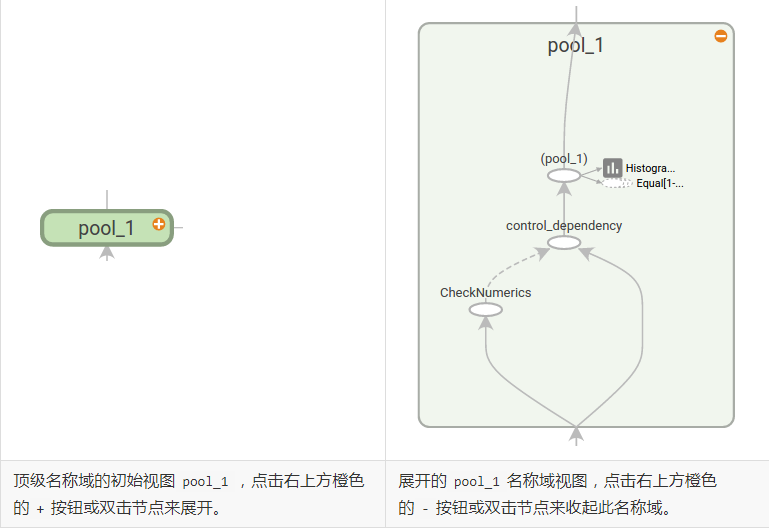

## Reference

* [详细解释CNN卷积神经网络各层的参数和链接个数的计算](https://blog.csdn.net/dcxhun3/article/details/46878999)

* [深度学习之卷积神经网络CNN及tensorflow代码实现示例](https://blog.csdn.net/cxmscb/article/details/71023576)